# Example code (A) 
## *The Statistical Trends of Protein Evolution: A Lesson from AlphaFold Database*

Qian-Yuan Tang, Weitong Ren, Jun Wang, Kunihiko Kaneko

Contact: tangqianyuan[at]gmail.com

## A. The calucations based on a given AlphaFold-predicted structure

In this Jupyter notebook, the following structural, topological, dynamical, and sequence-related descriptors of a given structure ('AF-Q9UHJ9-F1-model_v1.pdb.gz') are calculated.

### 1. Load the file, and calulate the basic structural descriptors

In [1]:
# Load basic python packages

import numpy as np
import os
import matplotlib.pyplot as plt

# Load Mdtraj package for the calculation of structural descriptors
# Mdtraj: analyze MD trajectories or protein structures (https://www.mdtraj.org/1.9.8.dev0/index.html)

import mdtraj as md

In [3]:
# Load protein file

Filename = 'AF-Q9UHJ9-F1-model_v1.pdb.gz'
traj = md.load(Filename)

# Calculate Radius of gyration (Rg in unit Angstrom)
rg = round(md.compute_rg(traj)[0]*10.,6)

# Calulate number of residues (N, chain length)
n_resi = traj.n_residues

#Calculate solvent-accessible surface area (SASA in unit Angstrom square).
sasa = md.shrake_rupley(traj)
area = round(sum(sasa[0])*100.,6)
area_per_resi = round(area/float(n_resi), 6)

print('Rg =', rg)
print('N =', n_resi)
print('SASA =', area)
print('SASA per residue =', area_per_resi)

Rg = 22.456806
N = 254
SASA = 15552.73072
SASA per residue = 61.231223


In [4]:
# Calculate the gyration tensor

gy_tensor = md.compute_gyration_tensor(traj)[0]

# Eigenvalues of the gyration tensor
eigs = np.linalg.eigvalsh(gy_tensor)*100.

# Length of the semi-axes
Lx = round(eigs[0]**.5, 6)
Ly = round(eigs[1]**.5, 6)
Lz = round(eigs[2]**.5, 6)

print('Lengths of the semi-axes =', Lx, Ly, Lz)

Lengths of the semi-axes = 7.299406 10.623903 18.389114


### 2. Secondary structure

In [5]:
# Calculation of DSSP (Define Secondary Structure of Proteins)

# The (unsimplified) DSSP assignment codes are: 

# 'H' : Alpha helix
# 'B' : Residue in isolated beta-bridge
# 'E' : Extended strand, participates in beta ladder
# 'G' : 3-helix (3/10 helix)
# 'I' : 5 helix (pi helix)
# 'T' : hydrogen bonded turn
# 'S' : bend
# ' ' : Loops and irregular elements'

dssp1 = md.compute_dssp(traj, simplified=False)[0]

# The simplified DSSP assignment codes are:

# 'H' : Helix. Either of the 'H', 'G', or 'I' codes.
# 'E' : Strand. Either of the 'E', or 'B' codes.
# 'C' : Coil. Either of the 'T', 'S' or ' ' codes.

dssp2 = md.compute_dssp(traj, simplified=True)[0]

In [6]:
# Calculate the loop/coil fraction

# Based on the unsimplified DSSP:

n_loop = 0
n_coil = 0

for w in dssp1:
    if w == ' ':
        n_loop += 1

for w in dssp2:
    if w == 'C':
        n_coil += 1
        
frac_loop = round(float(n_loop)/float(len(dssp1)), 6)
print('Loop fraction (based on unsimplifed DSSP): ', frac_loop)

frac_coil = round(float(n_coil)/float(len(dssp2)), 6)
print('Coil fraction (based on simplifed DSSP): ', frac_coil)

Loop fraction (based on unsimplifed DSSP):  0.145669
Coil fraction (based on simplifed DSSP):  0.255906


### 3. The calculation of topological descriptors

In [7]:
# Load the necessary packages
# - Prody: elastic network model calcualtions (http://prody.csb.pitt.edu/index.html)
# - Networkx: network analysis (https://networkx.org/)
# - Community: Network partition (https://python-louvain.readthedocs.io/en/latest/index.html)


from prody import *
import networkx as nx
import community

pdb_full = parsePDB(Filename)
calphas = pdb_full.select('calpha')
N = len(calphas)

# Cutoff distance
rc = 8.

# Build Kirchhoff matrix by Prody (graph Laplacain)
gnm = GNM('GNM_'+ Filename)
gnm.buildKirchhoff(calphas, cutoff=rc)
tmpHessian = gnm.getKirchhoff()

# Build the network by NetworkX
G = nx.Graph()
for i in range(N):
    # Add nodes
    G.add_node(i)
for i in range(N):
    for j in range(i+1, N):
        if j>i and tmpHessian[i][j]<-.9:
            # Add edges
            G.add_edge(i,j)
            
# Calculate Assortativity
assort = nx.degree_assortativity_coefficient(G)

# Find the partition of the network
parti = community.best_partition(G)

# Calculate modularity
Q = community.modularity(parti, G)

print('Assortativity: ', round(assort,6))
print('Modularity: ', round(Q,6))

@> 2074 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.


Assortativity:  0.41373
Modularity:  0.694829


### 4. Fractal dimension (based on box-counting method)

To estimate the fractal dimension of a protein, we first calculate the fractal dimension of every residue based on the box-counting method (counting how the number of neighboring residues increases as the cutoff distance increases) and then calculate the average over all the residues.

Fractal Dimension:  2.231232


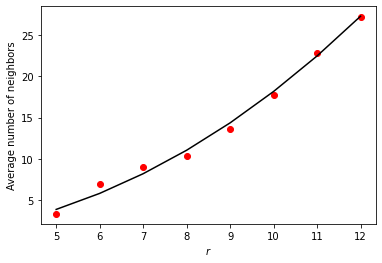

In [8]:
rclist = np.array([5, 6, 7, 8, 9, 10, 11, 12])

nb_all = []
Dist = buildDistMatrix(calphas)

# Changing the cutoff distances
for rc in rclist:
    nb = []
    for i in range(len(Dist)):
        # Calcualting the number of neighbors
        pos_count = len(list(filter(lambda x: (x <= rc), Dist[i])))
        nb.append(pos_count)
    nb_all.append(nb)

nb_all = np.array(nb_all)
nb_ave = np.array([round(np.mean(nb_all[k]),4) for k in range(len(nb_all))])

# Scattering plot
plt.plot(rclist, nb_ave, 'ro')
plt.xlabel('$r$')
plt.ylabel('Average number of neighbors')

# Log-log fitting
kb = np.polyfit(np.log(rclist), np.log(nb_ave), 1)
fitted = [np.exp(kb[0]*np.log(x)+kb[1]) for x in rclist]
plt.plot(rclist, fitted, 'k-')

# Fractal dimension
fract = round(kb[0], 6)
print('Fractal Dimension: ', fract)

### 5. Eigengaps and Zipf's coeffficients (based on elastic network models)

In [9]:
# Calculate the eigenvalues of the Hessian matrix

Eigs = np.linalg.eigvalsh(tmpHessian)

# Print the zero-th eigenvalue
print(Eigs[0])

# Print the first five eigenvalue (unnormalized)
print('Unnormalized Eigenvalues', Eigs[1:6])

# Normalize the eigenvalues
sumeigs = sum(Eigs)
NormEigs = Eigs/sumeigs*float(len(Eigs))

# Print the first five eigenvalue (normalized)
print('Normalized Eigenvalues',NormEigs[1:6])

# Calculate the eigengaps
print('Lambda2/Lambda1', round(NormEigs[2]/NormEigs[1], 6))
print('Lambda3/Lambda2', round(NormEigs[3]/NormEigs[2], 6))
print('Lambda4/Lambda3', round(NormEigs[4]/NormEigs[3], 6))


3.360821461564158e-16
Unnormalized Eigenvalues [0.06771152 0.17675373 0.22401456 0.41396638 0.43915161]
Normalized Eigenvalues [0.00721423 0.01883198 0.02386732 0.04410548 0.0467888 ]
Lambda2/Lambda1 2.610394
Lambda3/Lambda2 1.267382
Lambda4/Lambda3 1.847944


Text(0, 0.5, 'Eigenvalue $\\lambda_i$')

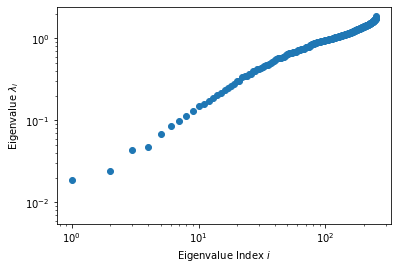

In [10]:
# Plot the normalized eigenvalues in the log-log scale
plt.loglog(NormEigs[1:], 'o')
plt.xlabel('Eigenvalue Index $i$')
plt.ylabel('Eigenvalue $\lambda_i$')

Zipf Coefficient z (fitted with 10% of the eigenvalues) 1.016895
Zipf Coefficient z (fitted with 25% of the eigenvalues) 0.861081
Zipf Coefficient z (fitted with 50% of the eigenvalues) 0.690232
Zipf Coefficient z (fitted with all the eigenvalues) 0.790732


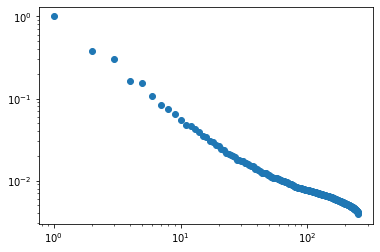

In [11]:
# Fit the Zipf coefficient

import powerlaw
# Here, python package 'powerlaw' is included (https://pypi.org/project/powerlaw/)

def fit_powerlaw(x, b):
    # The function that can fit the Zipf's coefficient
    # b denote the fraction of the eigenvalues to be fitted
    
    tmpdata = x[:int(len(x)*b)]
    fit = powerlaw.Fit(tmpdata, xmin=tmpdata[-1], discrete=False)
    alpha = fit.power_law.alpha
    z = round(1./(alpha-1.), 6)
    return z


# Plot the rank-size distribution of the inverse eigenvalues
invHessian = np.array([round(NormEigs[1]/t,6) for t in NormEigs[1:]])
index = [i+1 for i in range(len(invHessian))]
plt.loglog(index, invHessian, 'o')


z1 = fit_powerlaw(invHessian, 0.1)
z2 = fit_powerlaw(invHessian, 0.25)
z3 = fit_powerlaw(invHessian, 0.5)
z4 = fit_powerlaw(invHessian, 1.)
print('Zipf Coefficient z (fitted with 10% of the eigenvalues)', z1)
print('Zipf Coefficient z (fitted with 25% of the eigenvalues)', z2)
print('Zipf Coefficient z (fitted with 50% of the eigenvalues)', z3)
print('Zipf Coefficient z (fitted with all the eigenvalues)', z4)

### 6. pLDDT

AlphaFold produces a per-residue confidence metric called the predicted local distance difference test (pLDDT) on a scale from 0 to 100. Usually, residues with pLDDT ≤ 50 correspond to very low confidence, residues with 50 < pLDDT ≤ 70 have low confidence, and residues with 70 < pLDDT ≤ 90 correspond to a generally correct backbone prediction, and residues with pLDDT > 90 are expected to be modeled to high accuracy. 

Text(0, 0.5, 'pLDDT')

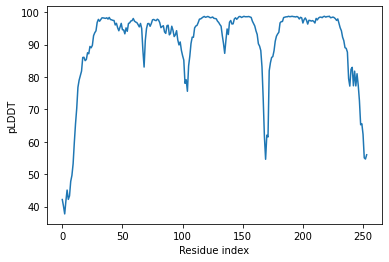

In [12]:
# In AlphaFold-predicted structures, the pLDDT is stored as the B-factors of the atoms.

plddt = calphas.getBetas()
plt.plot(plddt)
plt.xlabel('Residue index')
plt.ylabel('pLDDT')

### 7. Sequence (Hydrophobic-hydrophilic segregation)

MYQVPLPLDRDGTLVRLRFTMVALVTVCCPLVAFLFCILWSLLFHFKETTATHCGVPNYLPSVSSAIGGEVPQRYVWRFCIGLHSAPRFLVAFAYWNHYLSCTSPCSCYRPLCRLNFGLNVVENLALLVLTYVSSSEDFTIHENAFIVFIASSLGHMLLTCILWRLTKKHTVSQEDRKSYSWKQRLFIINFISFFSALAVYFRHNMYCEAGVYTIFAILEYTVVLTNMAFHMTAWWDFGNKELLITSQPEEKRF
CVHP =  0.260841


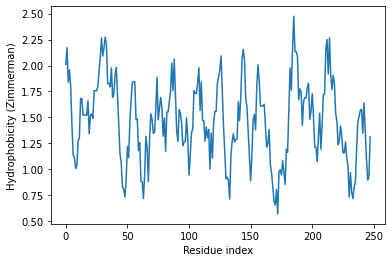

In [13]:
# Get sequence and print sequence
seq = calphas.getSequence()
print(seq)

# Load Biopython for sequence analysis
# Biopython: https://biopython.org/

from Bio.SeqUtils.ProtParam import ProteinAnalysis
analyzed_seq = ProteinAnalysis(seq)


# Set moving window size
iwindow = 7

# Zimmerman hydrophobicity scale
zi = {"A": 0.83, "R": 0.83, "N": 0.09, "D": 0.64, "C": 1.48,
      "Q": 0, "E": 0.65, "G": 0.1, "H": 1.1, "I": 3.07,
      "L": 2.52, "K": 1.6, "M": 1.4, "F": 2.75, "P": 2.7,
      "S": 0.14, "T": 0.54, "W": 0.31, "Y": 2.97, "V": 1.79}

# Other hydrophobicity scale can be accessed at: 
# https://github.com/biopython/biopython/blob/master/Bio/SeqUtils/ProtParamData.py

# Calculate and plot the hydrophathy profile of the protein 
scale_HP = analyzed_seq.protein_scale(window=iwindow, param_dict=zi)
plt.plot(scale_HP)
plt.xlabel('Residue index')
plt.ylabel('Hydrophobicity (Zimmerman)')


# Calculate CV_HP
ave = np.mean(scale_HP)
stdev = np.std(scale_HP)
CVHP = stdev/ave
print('CVHP = ', round(CVHP, 6))